# SCS matching – online BPTT – no read-out

This notebook implements the most basic model matching task.
Two models are instantiated, `scs` and `scs_target`, and the goal is for the activity
of `scs` to match that of `scs_target`.

Just for fun, we train in an online manner, so we see the match improve as
`scs` is integrated forward in time.

The notebook is organized as follows:

  - **Notebook intialization**\
    Imports and setting the random seed. Boring.
    
  - **Model instantiation**\
    Create the `scs` and `scs_target` instances. In this example there is no feedback,
    no external drive and no read-in or read-out vectors, so the dynamics of each model
    are simply given by
    $$\begin{aligned}
    h_{t} &= (1-Δt)h_{t-1} + J_t φ(h_{t-1}) \\
    φ(h_t) &= \tanh(g h_t)
    \end{aligned}$$
    where $Δt$ is our integration time step, $h_t \in \mathbb{R}^N$, $J_t \in \mathbb{M}_{N\times N}(\mathbb{R})$ and $g \in \mathbb{R}$.
    
  - **Integration of the target model**\
    Integrate the target model to generate data.
    
  - **Cost definition**\
    Define the cost we will optimize.
  
  - **Compilation of the training function**\
    Compile the aforedefined cost into a training function.
  
  - **Training the model**\
    Train the model using this compiled function.
  
  - **Plots**\
    Plot traces of the result.

## Notebook initialization

In [1]:
import numpy as np
import theano_shim as shim
from collections import OrderedDict
from types import SimpleNamespace
from inspect import signature

import mackelab_toolbox as mtb
import mackelab_toolbox.typing
import mackelab_toolbox.cgshim
from mackelab_toolbox.optimizers import Adam
from tqdm import tqdm

shim.load('theano')

mtb.typing.freeze_types()

from sinn.histories import TimeAxis

from bptt_sinn import SCS

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

Seed generated with

    np.random.SeedSequence().entropy

In [3]:
seed = 156096979187284293507501532684359637269
rng = np.random.default_rng(seed)

---
## Model instantiation

We set the following parameters:

| Parameter | Value |
|-----------|-------|
| $N$       | 10    |
| $J$       | $$\sim \mathcal{N}(0,1)$$ |
| $g$       | $$\sim \Gamma(2, 1/2)$$ |
| $\Delta t$      | $2^{-6}$|
| $t$       | $[0,40]$ |

In [4]:
N = 10
params_target = SCS.Parameters(
    N = N,
    J = rng.normal(size=(N,N)),
    g = rng.gamma(2, 0.5)
    )

TimeAxis.time_step = np.float64(2**-6)  # Powers of 2 minimize numerical error
time = TimeAxis(min=0, max=40)

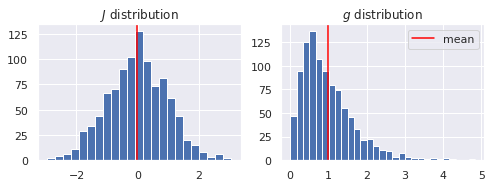

In [5]:
fig = plt.figure(figsize=(8,2.5))
axJ, axg = fig.subplots(1,2)
Jsamples = rng.normal(size=1000)
axJ.hist(Jsamples, bins='auto');
axJ.axvline(Jsamples.mean(), color='red', label='mean');
axJ.set_title("$J$ distribution");
gsamples = rng.gamma(2,0.5, size=1000)
axg.hist(gsamples, bins='auto');
axg.axvline(gsamples.mean(), color='red', label='mean');
axg.set_title("$g$ distribution");
axg.legend();

Create the target

In [6]:
scs_target = SCS(time=time, params=params_target, initializer=np.ones(N))

Create the model we will fit. 

In [7]:
params = params_target.copy()
params.J = shim.shared(rng.normal(size=(N,N)), name='J')
params.g = shim.shared(rng.gamma(2, 0.5), name='g')

In [8]:
scs = SCS(time=time, params=params, initializer=np.ones(N))

In [9]:
print(scs.summarize())

Model 'SCS' (t0: 0.0, tn: 40.0, dt: 0.015625)
---------------------------------------------
State variables: h
Parameters: N=10 J=J g=g




## Integrate the target

Integrate `scs_target` to generate our training data.\
Alternatively, we could also integrate it along with `scs` during training.
    
For comparison, we also integrate the untrained model.

In [ ]:
scs_target.advance(scs_target.tnidx)
scs.integrate(scs.tnidx)

Text(0.5, 1.0, 'Untrained activity')

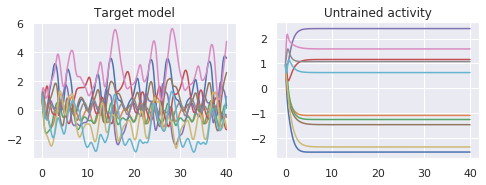

In [11]:
fig = plt.figure(figsize=(8,2.5))
ax_t, ax = fig.subplots(1, 2)
ax_t.plot(*scs_target.h.trace);
ax.plot(*scs.h.trace);
ax_t.set_title("Target model");
ax.set_title("Untrained activity");

We now lock `scs_target` to prevent further modifications.
This is also a necessary indication for *sinn*'s algorithms to work properly.

We also delete (`clear`) the simulation of the untrained model, so that it can be simulated again with training.

In [12]:
scs_target.h.lock()
scs.clear()

## Cost definition
We use a least squares loss.

The `scs.accumulate` decorator transforms a pointwise function into one that is accumulated (i.e. added) over sequential simulation steps of the `scs` model. The resulting `least_squares` function will take two arguments, a *starting point* and a *batch size*.

In [13]:
@scs.accumulate
def least_squares(tidx):
    return shim.mean((scs.h(tidx)-scs_target.h[tidx])**2)
print(f"least_squares{signature(least_squares)}")

least_squares(curtidx, batchsize)


## Compilation of the training function

Compilation happens in five steps:

  - Clear any lingering Theano updates.
  - Create an expression graph `cost` for the cost over a batch.
    We specify a symbolic start and batch size, because those will
    be parameters of the final compiled function.
  - Create an expression graph for the parameter updates.\
    This involves differenting `cost`; here we use the *Adam* algorithm.
  - Compile the expression for the parameter updates.
  - Clear the Theano updates we just created.

*sinn* models provide three symbolic variables for compiling accumulators:\
`curtidx_var`, `batchsize_var` and `stoptidx_var`. It's not necessary to use them, but generally more convenient.

We also need to set a learning rate; we use a shared variable here so that it can be changed later, or even in the middle of training.

In [14]:
lrJ = shim.shared(np.array(1, dtype=shim.config.floatX), name='learning rate (J)')
lrg = shim.shared(np.array(1, dtype=shim.config.floatX), name='learning rate (g)')
    # Value of 1 is arbitrary; we will change it
lr = {scs.params.J: lrJ,
      scs.params.g: lrg}

In [15]:
shim.reset_updates()
scs.theano_reset()

In [16]:
cost, upds = least_squares(scs.curtidx_var, scs.batchsize_var)

The argument `params` to `Adam` allows us to specify which parameters we want to optimize.

In [17]:
optimizer_upds = Adam(cost,
                      params=[scs.J, scs.g],
                      lr=lr
                     )
update_parameters = shim.graph.compile(
    inputs  = [scs.curtidx_var, scs.batchsize_var],
    outputs = [],
    updates = optimizer_upds
)

In [18]:
shim.reset_updates()
scs.theano_reset()

## Train the model

We define a function `integrate_and_train`, which takes two arguments:

  - `endtidx`: Model will be integrated up to this point inclusive.
  - `unroll_len`: The number of time steps to unroll for back propagation.
     Large values will substantially increase computation time.
     
At every time step, this function will update the parameters, and then integrate one time step more. We could of course use different schemes, e.g. updating only after $n$ steps.

In [19]:
def integrate_and_train(endtidx, unroll_len):
    starttidx = scs.cur_tidx+1
    for idx in tqdm(range(starttidx, endtidx+1)):
        # Update the parameters, applying bptt starting at the current index
        update_parameters(idx-unroll_len, unroll_len)
        # Integrate the model one more step
        scs.integrate(idx)

Set the learning rate and make a copy of the original parameters

|              |      |   |
|--------------|------|---|
|learning rate | `lr` | 0.5 |

In [20]:
target_params = scs_target.params

In [21]:
untrained_params = scs.Parameters(**{p: shim.eval(v)
                                 for p,v in scs.params.dict().items()})

In [22]:
lrg.set_value(0.01)
lrJ.set_value(0.5)

First integrate a few time steps without training. This needs to be at least as much as the value of `unroll_len` we wish to use.

In [23]:
# Reset training
scs.clear()
scs.J.set_value(untrained_params.J)
scs.g.set_value(untrained_params.g)

In [24]:
scs.integrate(50)

Now integrate the rest of the way, training at every time step.

In [25]:
integrate_and_train(scs.tnidx, unroll_len=20)

100%|██████████| 2510/2510 [00:36<00:00, 69.18it/s]


In [26]:
trained_params = scs.Parameters(**{p: shim.eval(v)
                                 for p,v in scs.params.dict().items()})

## Results

In [27]:
print("before\n-------")
print(f"J[0,:3]: {untrained_params.J[0,:3]}")
print(f"g:       {untrained_params.g}")
print("\nafter\n--------")
print(f"J[0,:3]: {trained_params.J[0,:3]}")
print(f"g:       {trained_params.g}")
print("\ntarget\n--------")
print(f"J[0,:3]: {target_params.J[0,:3]}")
print(f"g:       {target_params.g}")

before
-------
J[0,:3]: [ 0.23172086 -0.4797614   0.49169881]
g:       2.2164129672110042

after
--------
J[0,:3]: [-19.91479771   9.62581297   1.91829175]
g:       0.6829904793177085

target
--------
J[0,:3]: [-0.03639079 -0.88125234 -1.63968058]
g:       1.7061530185421785


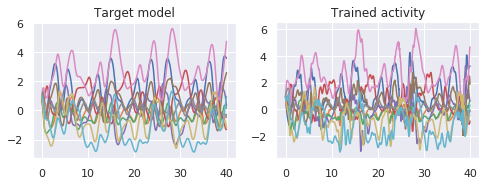

In [30]:
fig = plt.figure(figsize=(8,2.5))
ax_t, ax = fig.subplots(1, 2)
ax_t.plot(*scs_target.h.trace);
ax.plot(*scs.h.trace);
ax_t.set_title("Target model");
ax.set_title("Trained activity");

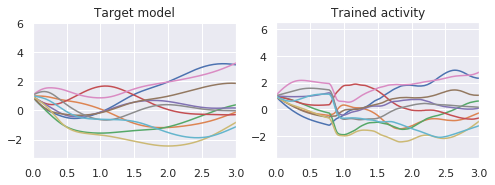

In [31]:
fig = plt.figure(figsize=(8,2.5))
ax_t, ax = fig.subplots(1, 2)
ax_t.plot(*scs_target.h.trace);
ax.plot(*scs.h.trace);
ax_t.set_xlim(0,3);
ax.set_xlim(0,3);
ax_t.set_title("Target model");
ax.set_title("Trained activity");